<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/DataCollectionFixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance textblob ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5f19adb14da78f96c8c0d55a215abf95b3017624d91e979485d53a79ebad44f0
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import os
import requests
import datetime
import pandas as pd
import time
from google.colab import userdata  # For fetching stored API keys
from textblob import TextBlob

def fetch_stock_data_polygon(ticker, start_date, end_date, api_key):
    """
    Fetches historical stock data from Polygon.io.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?apiKey={api_key}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error fetching stock data: {response.text}")
        return None

    data = response.json()
    if "results" not in data:
        print("No results found.")
        return None

    # Convert response to DataFrame
    df = pd.DataFrame(data["results"])
    df["Date"] = pd.to_datetime(df["t"], unit="ms").dt.date
    df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

    return df

def fetch_sentiment_data_polygon(ticker, start_date, end_date, api_key, limit=1000):
    """
    Fetches sentiment data from Polygon.io in chunks and computes daily sentiment scores.
    """
    url = "https://api.polygon.io/v2/reference/news"
    all_results = []
    current_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    final_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    while current_start_date < final_end_date:
        chunk_end_date = current_start_date + datetime.timedelta(days=30)
        if chunk_end_date > final_end_date:
            chunk_end_date = final_end_date

        chunk_start_str = current_start_date.strftime("%Y-%m-%d")
        chunk_end_str = chunk_end_date.strftime("%Y-%m-%d")

        print(f"📡 Fetching sentiment data from {chunk_start_str} to {chunk_end_str}...")

        params = {
            "ticker": ticker,
            "published_utc.gte": chunk_start_str,
            "published_utc.lte": chunk_end_str,
            "apiKey": api_key,
            "limit": limit
        }

        while True:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                results = data.get("results", [])
                all_results.extend(results)

                next_cursor = data.get("next_cursor")
                if not next_cursor:
                    break

                params["cursor"] = next_cursor
            else:
                print(f"⚠️ Error fetching sentiment data: {response.status_code}, {response.text}")
                break

        current_start_date = chunk_end_date
        time.sleep(14)  # Avoid hitting API rate limits

    return all_results

def analyze_sentiment(news_data):
    """
    Uses TextBlob to compute sentiment polarity and subjectivity for each news article.
    """
    analyzed_data = []
    for article in news_data:
        title = article.get("title", "")
        description = article.get("description", "")
        full_text = f"{title} {description}"
        sentiment = TextBlob(full_text).sentiment

        analyzed_data.append({
            "title": title,
            "description": description,
            "published_date": article.get("published_utc", ""),
            "sentiment_polarity": sentiment.polarity,
            "sentiment_subjectivity": sentiment.subjectivity
        })

    return analyzed_data

def merge_stock_and_sentiment(stock_df, sentiment_data):
    """
    Merges stock data with sentiment data by date.
    """
    sentiment_df = pd.DataFrame(sentiment_data)

    if sentiment_df.empty:
        print("⚠️ No sentiment data found, proceeding without sentiment.")
        stock_df["sentiment_polarity"] = 0  # Default neutral
        stock_df["sentiment_subjectivity"] = 0
        return stock_df

    sentiment_df['published_date'] = pd.to_datetime(sentiment_df['published_date'], errors='coerce')
    sentiment_df['Date'] = sentiment_df['published_date'].dt.date

    # Group sentiment data by date
    daily_sentiment = sentiment_df.groupby('Date').agg({
        'sentiment_polarity': 'mean',
        'sentiment_subjectivity': 'mean'
    }).reset_index()

    # Merge with stock data
    merged_df = pd.merge(stock_df, daily_sentiment, on="Date", how="left")

    # Handle missing sentiment values (forward fill) while ensuring numeric dtype
    merged_df[['sentiment_polarity', 'sentiment_subjectivity']] = (
        merged_df[['sentiment_polarity', 'sentiment_subjectivity']]
        .replace(0, pd.NA)  # Convert zeros to NaN
        .infer_objects(copy=False)  # Ensure numeric dtype
        .ffill()  # Forward fill missing values
    )
    # Fill any remaining NaN values
    merged_df.fillna(0, inplace=True)

    return merged_df

def main():
    """
    Main function to fetch stock data and sentiment data, merge them, and save to a raw CSV file.
    """
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Set fixed start date
    start_date = "2021-01-01"
    end_date = today

    # Ask user for stock ticker
    ticker = input("Enter the stock ticker (e.g., TSLA): ").strip().upper()

    # Load Polygon API key
    api_key = userdata.get("Polygon_Key")
    if not api_key:
        print("❌ Error: Polygon API key not found.")
        return

    # Fetch stock data
    print(f"\n📊 Fetching stock data for {ticker} from {start_date} to {end_date}...")
    stock_df = fetch_stock_data_polygon(ticker, start_date, end_date, api_key)

    if stock_df is None:
        print("❌ No stock data found. Exiting.")
        return

    # Fetch sentiment data
    print(f"\n📰 Fetching sentiment data for {ticker} from {start_date} to {end_date}...")
    news_data = fetch_sentiment_data_polygon(ticker, start_date, end_date, api_key, limit=1000)

    if not news_data:
        print("⚠️ No news data found. Proceeding without sentiment data.")

    print("\n💡 Performing sentiment analysis...")
    sentiment_data = analyze_sentiment(news_data)

    # Merge stock and sentiment data
    print("\n🔗 Merging stock and sentiment data...")
    merged_df = merge_stock_and_sentiment(stock_df, sentiment_data)

    # Save raw data
    filename = f"{ticker}_{start_date}_to_{end_date}_raw.csv"
    merged_df.to_csv(filename, index=False)
    print(f"✅ Raw stock data with sentiment saved to: {filename}")

# Run the main function
if __name__ == "__main__":
    main()


Enter the stock ticker (e.g., TSLA): qqq

📊 Fetching stock data for QQQ from 2021-01-01 to 2025-03-03...

📰 Fetching sentiment data for QQQ from 2021-01-01 to 2025-03-03...
📡 Fetching sentiment data from 2021-01-01 to 2021-01-31...
📡 Fetching sentiment data from 2021-01-31 to 2021-03-02...
📡 Fetching sentiment data from 2021-03-02 to 2021-04-01...
📡 Fetching sentiment data from 2021-04-01 to 2021-05-01...
📡 Fetching sentiment data from 2021-05-01 to 2021-05-31...
📡 Fetching sentiment data from 2021-05-31 to 2021-06-30...
📡 Fetching sentiment data from 2021-06-30 to 2021-07-30...
📡 Fetching sentiment data from 2021-07-30 to 2021-08-29...
📡 Fetching sentiment data from 2021-08-29 to 2021-09-28...
📡 Fetching sentiment data from 2021-09-28 to 2021-10-28...
📡 Fetching sentiment data from 2021-10-28 to 2021-11-27...
📡 Fetching sentiment data from 2021-11-27 to 2021-12-27...
📡 Fetching sentiment data from 2021-12-27 to 2022-01-26...
📡 Fetching sentiment data from 2022-01-26 to 2022-02-25...
📡

<ipython-input-2-24227b23c8f6>:131: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()  # Forward fill missing values


In [9]:
import os
import re
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from ta.momentum import RSIIndicator, WilliamsRIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands, AverageTrueRange

def get_valid_files():
    """Detects and lists valid raw stock data files in Colab's working directory."""
    uploaded_files = os.listdir("/content")
    pattern = re.compile(r"^([A-Za-z]+)_\d{4}-\d{2}-\d{2}_to_\d{4}-\d{2}-\d{2}_raw\.csv$", re.IGNORECASE)
    valid_files = {f: pattern.match(f).group(1).upper() for f in uploaded_files if pattern.match(f)}
    return valid_files

def select_file():
    """Selects the most recent stock data file or prompts the user to choose if multiple are found."""
    valid_files = get_valid_files()

    if not valid_files:
        print("❌ No valid raw stock data files found. Please upload one to /content.")
        return None, None

    if len(valid_files) == 1:
        filename = list(valid_files.keys())[0]
        stock_ticker = valid_files[filename]
        print(f"✅ Automatically selected: {filename} ({stock_ticker})")
        return filename, stock_ticker

    print("🔍 Multiple stock raw files detected. Please choose one:")
    for i, fname in enumerate(valid_files.keys()):
        print(f"{i + 1}. {fname} ({valid_files[fname]})")

    choice = int(input("Enter the number of the file to use: ")) - 1
    filename = list(valid_files.keys())[choice]
    stock_ticker = valid_files[filename]

    print(f"✅ Selected: {filename} ({stock_ticker})")
    return filename, stock_ticker

def preprocess_stock_data(file_name, output_dir="/content"):
    df = pd.read_csv(file_name)
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

    # === Add Technical Indicators ===
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi().shift(1)
    df["MACD"] = MACD(close=df["Close"]).macd().shift(1)
    df["ATR"] = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"]).average_true_range().shift(1)

    bb = BollingerBands(close=df["Close"])
    df["BB_High"] = bb.bollinger_hband().shift(1)
    df["BB_Low"] = bb.bollinger_lband().shift(1)

    df["Williams_%R"] = WilliamsRIndicator(high=df["High"], low=df["Low"], close=df["Close"]).williams_r().shift(1)

    # === Handle Sentiment Data Correctly ===
    df['sentiment_polarity'] = df['sentiment_polarity'].rolling(7, min_periods=1).mean()
    df['sentiment_subjectivity'] = df['sentiment_subjectivity'].rolling(7, min_periods=1).mean()

    # === Fill NaNs AFTER Computing Features ===
    df.ffill(inplace=True)
    df.bfill(inplace=True)  # Extra safety to remove NaNs at start
    df.dropna(inplace=True)  # Drop any lingering NaNs

    # === Define Feature Groups ===
    stock_features = ["Open", "High", "Low", "Volume", "ATR", "BB_High", "BB_Low", "Williams_%R", "RSI", "MACD"]
    sentiment_features = ["sentiment_polarity", "sentiment_subjectivity"]

    # === Scale Stock Data ===
    scaler_x_stock = MinMaxScaler()
    X_stock_scaled = scaler_x_stock.fit_transform(df[stock_features])

    # === Scale Sentiment Data ===
    X_sentiment_scaled = df[sentiment_features].copy()
    X_sentiment_scaled["sentiment_subjectivity"] = MinMaxScaler().fit_transform(df[["sentiment_subjectivity"]])

    # Combine scaled stock & sentiment features
    X_final = np.hstack((X_stock_scaled, X_sentiment_scaled))

    # Scale target (Close Price)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(df[["Close"]])

    # Save scalers for later use
    joblib.dump(scaler_x_stock, os.path.join(output_dir, "scaler_x_stock.pkl"))
    joblib.dump(scaler_y, os.path.join(output_dir, "scaler_y.pkl"))

    # === Convert to Sequences for Model Training ===
    sequence_length = 30
    X_seq, y_seq = [], []
    for i in range(len(X_final) - sequence_length):
        X_seq.append(X_final[i : i + sequence_length])
        y_seq.append(y_scaled[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # === Train (64%), Validation (16%), and Test (20%) Split ===
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Save Processed Datasets
    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "X_val.npy"), X_val)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "y_val.npy"), y_val)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)

    print("✅ Preprocessing Complete! NaNs removed.")

    return os.path.join(output_dir, "scaler_x_stock.pkl"), os.path.join(output_dir, "scaler_y.pkl")

def main():
    """Main function to detect and process stock data."""
    file_name, ticker = select_file()

    if file_name:
        preprocess_stock_data(os.path.join("/content", file_name))
    else:
        print("❌ No valid file selected. Exiting.")

if __name__ == "__main__":
    main()

✅ Automatically selected: QQQ_2021-01-01_to_2025-03-03_raw.csv (QQQ)
✅ Preprocessing Complete! NaNs removed.


In [10]:
import numpy as np
import joblib
import os

# Verify that files exist
files_to_check = [
    "X_train.npy", "X_val.npy", "X_test.npy",
    "y_train.npy", "y_val.npy", "y_test.npy",
    "scaler_x_stock.pkl", "scaler_y.pkl"
]

missing_files = [f for f in files_to_check if not os.path.exists(f)]
if missing_files:
    print("❌ Missing files:", missing_files)
else:
    print("✅ All expected files are present.")

# Load datasets
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

# Load scalers
scaler_x_stock = joblib.load("scaler_x_stock.pkl")
scaler_y = joblib.load("scaler_y.pkl")

# Print dataset shapes
print("📊 Dataset Shapes:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

# Print Min/Max Values of Scaled Target (y)
y_train_min, y_train_max = y_train.min(), y_train.max()
y_test_min, y_test_max = y_test.min(), y_test.max()
print("🔍 Scaled Target (y) Min/Max:")
print(f"y_train: Min={y_train_min}, Max={y_train_max}")
print(f"y_test: Min={y_test_min}, Max={y_test_max}")

# Output sample values to verify correctness
output_check = {
    "X_train_sample": X_train[0, 0, :].tolist(),
    "y_train_sample": y_train[0].tolist(),
    "X_test_sample": X_test[0, 0, :].tolist(),
    "y_test_sample": y_test[0].tolist()
}

print("🔹 Sample Output Check (Send this back to me if needed):")
print(output_check)

✅ All expected files are present.
📊 Dataset Shapes:
X_train: (300, 30, 12), X_val: (75, 30, 12), X_test: (94, 30, 12)
y_train: (300, 1), y_val: (75, 1), y_test: (94, 1)
🔍 Scaled Target (y) Min/Max:
y_train: Min=0.08542853727537159, Max=0.7835996334223214
y_test: Min=0.7781806590429137, Max=1.0
🔹 Sample Output Check (Send this back to me if needed):
{'X_train_sample': [0.05616600790513826, 0.03915442668181446, 0.058224220957535655, 0.49609584388861294, 0.0, 0.0, 0.0011263591762729064, 0.816780776570694, 0.6712762994727811, 0.7282581355876999, -0.0058501683501683, 0.0], 'y_train_sample': [0.12077140694106858], 'X_test_sample': [0.7443083003952569, 0.74068814412075, 0.7375333306801446, 0.2090422245140264, 0.7806715966156057, 0.7784983179573441, 0.6373433594886295, 0.5962922611672716, 0.40181336717862937, 0.6130554470368665, 0.12409219748505458, 0.5217420500413109], 'y_test_sample': [0.8325696298362355]}


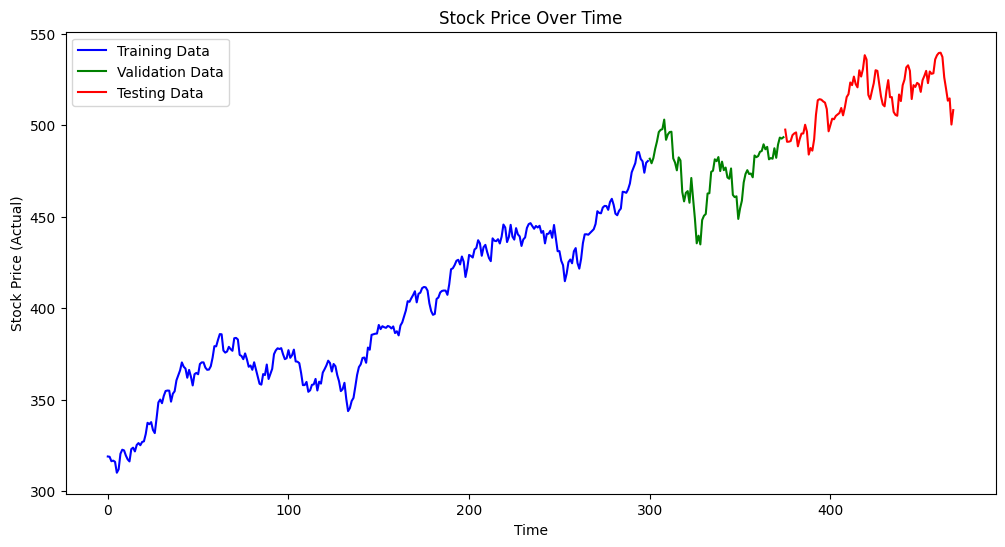

✅ Stock price plot generated successfully!


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# === Load Preprocessed Data ===
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

# === Load Scaler for Target Variable ===
scaler_y = joblib.load("scaler_y.pkl")

# === Ensure Target Values Are Correctly Shaped ===
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# === Inverse Transform Target Values ===
y_train_unscaled = scaler_y.inverse_transform(y_train)
y_val_unscaled = scaler_y.inverse_transform(y_val)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# === Plot Actual Stock Price Over Time ===
plt.figure(figsize=(12,6))

# Plot training data
plt.plot(y_train_unscaled, label="Training Data", color="blue")

# Plot validation data (shifted forward)
plt.plot(range(len(y_train_unscaled), len(y_train_unscaled) + len(y_val_unscaled)),
         y_val_unscaled, label="Validation Data", color="green")

# Plot testing data (shifted forward)
plt.plot(range(len(y_train_unscaled) + len(y_val_unscaled),
               len(y_train_unscaled) + len(y_val_unscaled) + len(y_test_unscaled)),
         y_test_unscaled, label="Testing Data", color="red")

plt.xlabel("Time")
plt.ylabel("Stock Price (Actual)")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()

print("✅ Stock price plot generated successfully!")
